In [1]:
import numpy as np
import torch
import os
from torch.utils.data import Dataset, DataLoader

class SymileMIMICTripletDataset(Dataset):
    """
    Simple triplet dataset for Symile-MIMIC:

    Returns a dict with:
        {
            "cxr":  (3, 320, 320) float32
            "ecg":  (1, 5000, 12) float32
            "labs": (100,)        float32  [50 percentiles || 50 missingness]
        }

    This uses the preprocessed .npy tensors from data_npy/<split>/.
    It ignores retrieval labels, hadm_ids, etc. — those are not needed
    for PACX-MAE teacher–student training.
    """

    def __init__(
        self,
        data_npy_root: str,
        split: str = "train",
        load_hadm_ids: bool = False,
    ):
        """
        Args:
            data_npy_root: Path to the `data_npy` directory described in the Symile-MIMIC docs.
                           Inside, we expect subdirs train/, val/, val_retrieval/, test/.
            split: "train", "val", "val_retrieval", or "test".
            load_hadm_ids: If True, also load hadm_id_<split>.npy and expose in __getitem__.
                           PACX-MAE doesn't need it, but you might for logging.
        """
        super().__init__()
        self.data_npy_root = data_npy_root
        self.split = split
        self.load_hadm_ids = load_hadm_ids

        # Directory for this split: e.g. data_npy/train, data_npy/val, ...
        split_dir = os.path.join(self.data_npy_root, split)

        if not os.path.isdir(split_dir):
            raise FileNotFoundError(f"Split directory not found: {split_dir}")

        # Core triplet arrays
        cxr_path = os.path.join(split_dir, f"cxr_{split}.npy")
        ecg_path = os.path.join(split_dir, f"ecg_{split}.npy")
        labs_pct_path = os.path.join(split_dir, f"labs_percentiles_{split}.npy")
        labs_miss_path = os.path.join(split_dir, f"labs_missingness_{split}.npy")

        if not all(os.path.exists(p) for p in [cxr_path, ecg_path, labs_pct_path, labs_miss_path]):
            missing = [p for p in [cxr_path, ecg_path, labs_pct_path, labs_miss_path] if not os.path.exists(p)]
            raise FileNotFoundError(f"Missing required .npy files for split '{split}': {missing}")

        # Load into memory. For large setups, you could mmap or lazy-load, but 11k is fine.
        self.cxr = np.load(cxr_path)                # shape: (N, 3, 320, 320)
        self.ecg = np.load(ecg_path)                # shape: (N, 1, 5000, 12)
        self.labs_percentiles = np.load(labs_pct_path)   # shape: (N, 50)
        self.labs_missingness = np.load(labs_miss_path)  # shape: (N, 50)

        # Optional hadm_ids
        self.hadm_ids = None
        if self.load_hadm_ids:
            hadm_path = os.path.join(split_dir, f"hadm_id_{split}.npy")
            if os.path.exists(hadm_path):
                self.hadm_ids = np.load(hadm_path)
            else:
                # Not fatal; just warn
                print(f"[SymileMIMICTripletDataset] hadm_id file not found for split {split}: {hadm_path}")

        # Basic consistency checks
        n = self.cxr.shape[0]
        assert self.ecg.shape[0] == n, "ECG and CXR length mismatch"
        assert self.labs_percentiles.shape[0] == n, "labs_percentiles and CXR length mismatch"
        assert self.labs_missingness.shape[0] == n, "labs_missingness and CXR length mismatch"
        if self.hadm_ids is not None:
            assert self.hadm_ids.shape[0] == n, "hadm_ids and CXR length mismatch"

    def __len__(self) -> int:
        return self.cxr.shape[0]

    def __getitem__(self, idx: int):
        # Load numpy slices
        cxr = self.cxr[idx]                  # (3, 320, 320)
        ecg = self.ecg[idx]                  # (1, 5000, 12)
        labs_pct = self.labs_percentiles[idx]     # (50,)
        labs_miss = self.labs_missingness[idx]    # (50,)

        # Concatenate to 100-dim vector: [percentiles | missingness]
        labs = np.concatenate([labs_pct, labs_miss], axis=0)  # (100,)

        # Convert to torch tensors (float32)
        cxr = torch.from_numpy(cxr).float()
        ecg = torch.from_numpy(ecg).float()
        labs = torch.from_numpy(labs).float()

        sample = {
            "cxr": cxr,
            "ecg": ecg,
            "labs": labs,
        }

        if self.hadm_ids is not None:
            sample["hadm_id"] = torch.as_tensor(self.hadm_ids[idx])

        return sample

test_ds = SymileMIMICTripletDataset(data_npy_root="../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy", 
                                    split="test", 
                                    load_hadm_ids=False)

In [2]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)

batch = next(iter(test_loader))
print("CXR batch shape:", batch["cxr"].shape)    # (B, 3, 320, 320)
print("ECG batch shape:", batch["ecg"].shape)    # (B, 1, 5000, 12)
print("Labs batch shape:", batch["labs"].shape)  # (B, 100)
print("Dtypes:", batch["cxr"].dtype, batch["ecg"].dtype, batch["labs"].dtype)

CXR batch shape: torch.Size([8, 3, 320, 320])
ECG batch shape: torch.Size([8, 1, 5000, 12])
Labs batch shape: torch.Size([8, 100])
Dtypes: torch.float32 torch.float32 torch.float32


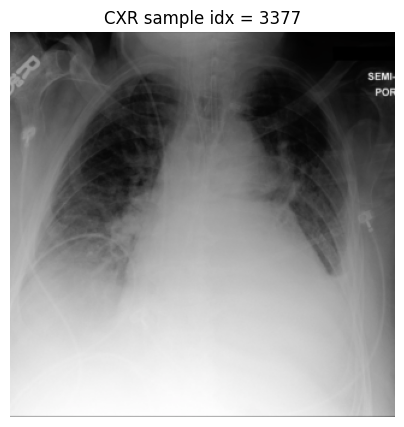

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl
import torchvision.transforms as T
from typing import Optional, Dict, Tuple, List

class UnNormalize(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean = torch.tensor(mean).view(3, 1, 1)
        self.std = torch.tensor(std).view(3, 1, 1)

    def forward(self, tensor):
        # x = (x - mean) / std  <-- Original Normalization
        # x * std + mean        <-- Undo
        return tensor * self.std.to(tensor.device) + self.mean.to(tensor.device)

un = UnNormalize()

def show_cxr_from_dataset(ds, idx=None):
    if idx is None:
        idx = random.randint(0, len(ds) - 1)
    sample = ds[idx]


    cxr = sample["cxr"]                # (3, 320, 320) tensor
    cxr = un(cxr)


    cxr_np = cxr.numpy()

    # Convert to HWC
    cxr_np = np.transpose(cxr_np, (1, 2, 0))  # (320, 320, 3)

    # Many CXRs are effectively grayscale replicated on 3 channels
    plt.figure(figsize=(5, 5))
    plt.imshow(cxr_np, cmap="gray")
    plt.axis("off")
    plt.title(f"CXR sample idx = {idx}")
    plt.show()

    return sample, idx

sample, idx = show_cxr_from_dataset(test_ds)


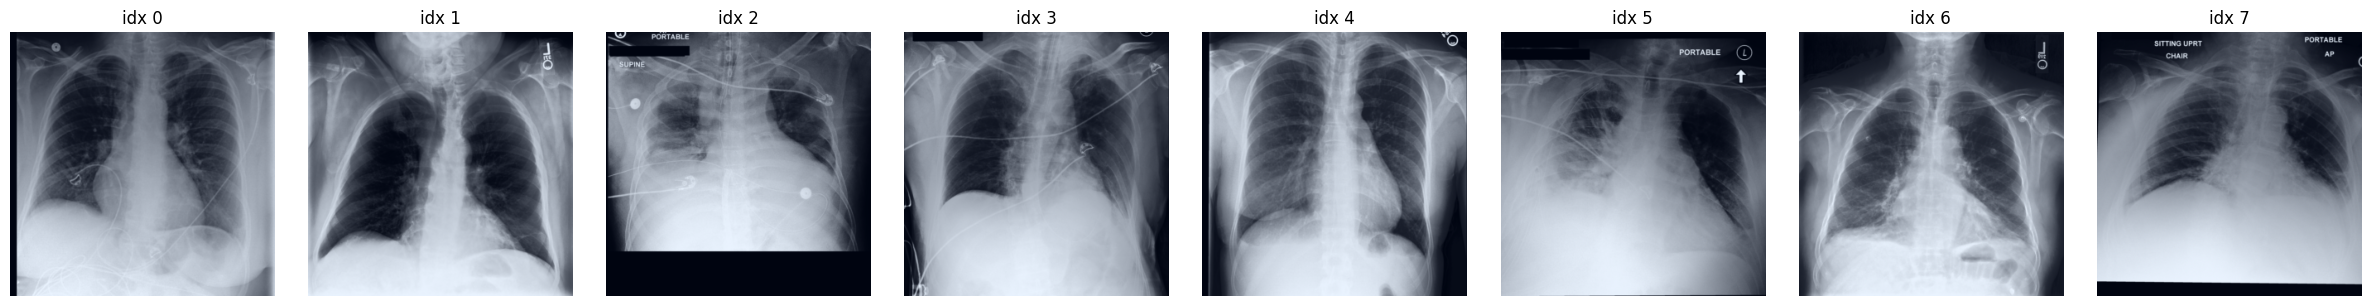

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_first_n_cxrs(ds, n=8):
    plt.figure(figsize=(3*n, 3))

    for i in range(n):
        sample = ds[i]
        cxr = sample["cxr"].numpy()              # (3, 320, 320)
        cxr_np = np.transpose(cxr, (1, 2, 0))    # (320, 320, 3)

        # min-max normalize for visualization
        cxr_min, cxr_max = cxr_np.min(), cxr_np.max()
        cxr_vis = (cxr_np - cxr_min) / (cxr_max - cxr_min + 1e-6)

        plt.subplot(1, n, i+1)
        plt.imshow(cxr_vis, cmap="gray")
        plt.axis("off")
        plt.title(f"idx {i}")

    plt.tight_layout()
    plt.show()

# Call it:
show_first_n_cxrs(test_ds, n=8)


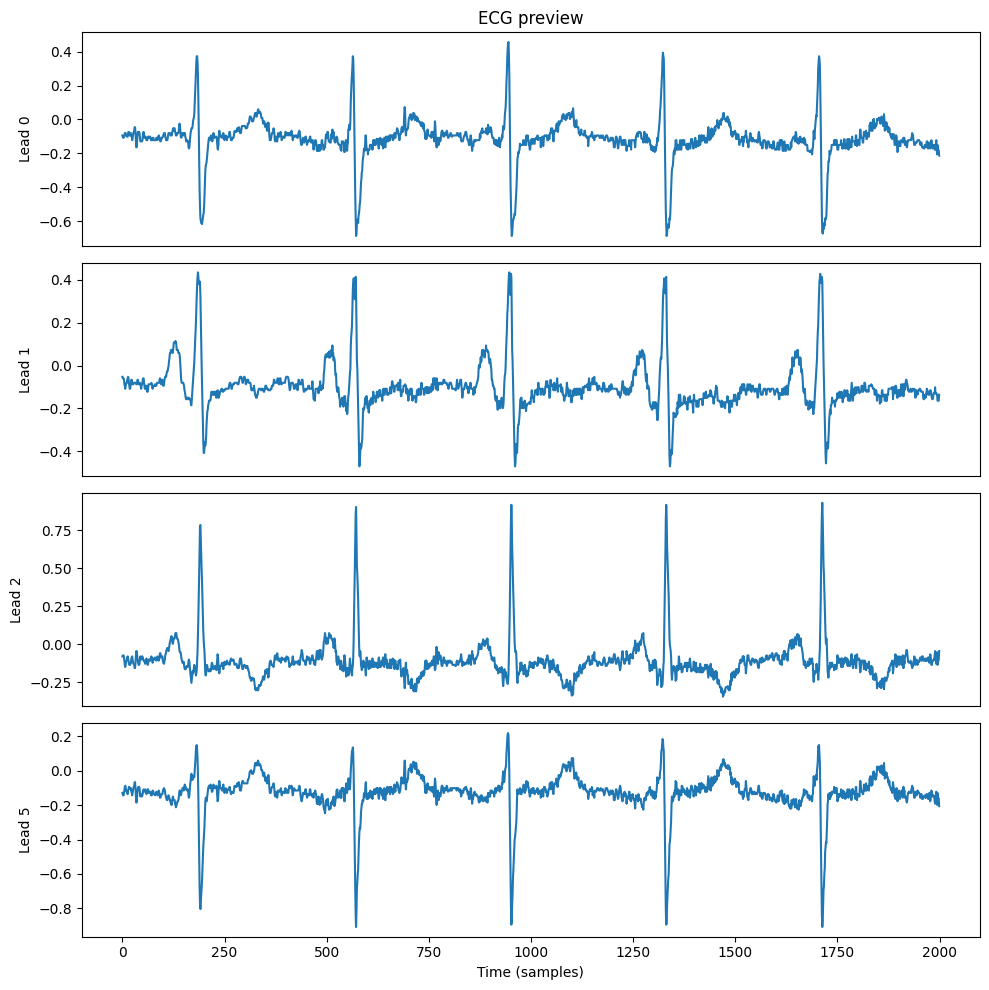

In [5]:
def plot_ecg_sample(sample, leads_to_plot=(0, 1, 2), max_points=2000):
    ecg = sample["ecg"].numpy()   # (1, 5000, 12)
    ecg = ecg[0]                  # (5000, 12)

    length = min(ecg.shape[0], max_points)
    t = np.arange(length)  # if you know sampling rate fs, use t = np.arange(length)/fs

    n_leads = len(leads_to_plot)
    plt.figure(figsize=(10, 2.5 * n_leads))

    for i, lead in enumerate(leads_to_plot, 1):
        plt.subplot(n_leads, 1, i)
        plt.plot(t, ecg[:length, lead])
        plt.ylabel(f"Lead {lead}")
        if i == 1:
            plt.title("ECG preview")
        if i != n_leads:
            plt.xticks([])
    plt.xlabel("Time (samples)")
    plt.tight_layout()
    plt.show()

plot_ecg_sample(sample, leads_to_plot=(0, 1, 2, 5))

Labs percentiles (first 10): [0.27348736 0.18688092 0.51649284 0.17367378 0.57957196 0.34932864
 0.50931823 0.5210747  0.50365525 0.3095885 ]
Labs missingness (first 10): [1. 1. 0. 1. 1. 1. 0. 0. 0. 1.]
Percentiles stats -> min: 0.14144869 max: 0.99638337 mean: 0.53336215 std: 0.21407273
Missingness unique values: [0. 1.]


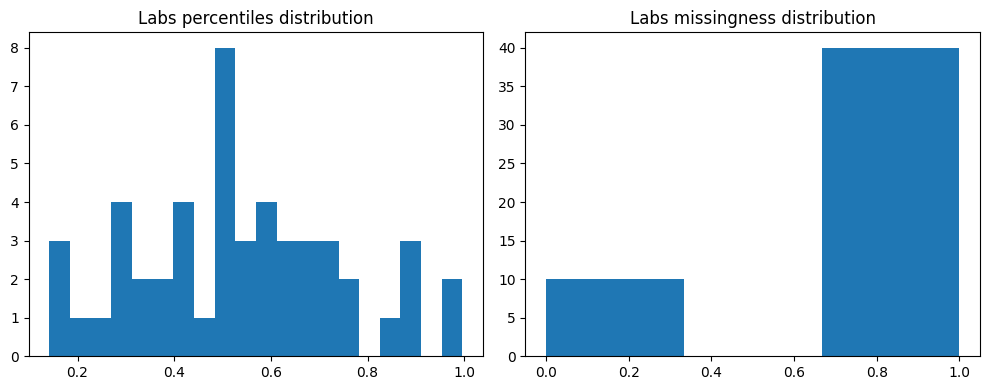

In [6]:
def inspect_labs_sample(sample):
    labs = sample["labs"].numpy()          # (100,)
    labs_pct = labs[:50]
    labs_miss = labs[50:]

    print("Labs percentiles (first 10):", labs_pct[:10])
    print("Labs missingness (first 10):", labs_miss[:10])

    print("Percentiles stats -> min:", labs_pct.min(), "max:", labs_pct.max(),
          "mean:", labs_pct.mean(), "std:", labs_pct.std())
    print("Missingness unique values:", np.unique(labs_miss))

    # Quick visualization
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(labs_pct, bins=20)
    plt.title("Labs percentiles distribution")

    plt.subplot(1, 2, 2)
    plt.hist(labs_miss, bins=3)
    plt.title("Labs missingness distribution")
    plt.tight_layout()
    plt.show()

inspect_labs_sample(sample)


=== CXR stats ===
Pixel min across ds: -2.117904
Pixel max across ds: 2.64

=== ECG stats ===
ECG min across ds: -1.0
ECG max across ds: 1.0

=== Labs percentiles stats (over all samples & dims) ===
min: 0.0 max: 1.0
mean: 0.5204804 std: 0.23846245

=== Labs missingness stats ===
unique values: [0. 1.]
fraction of missing (≈1s): 0.70589846


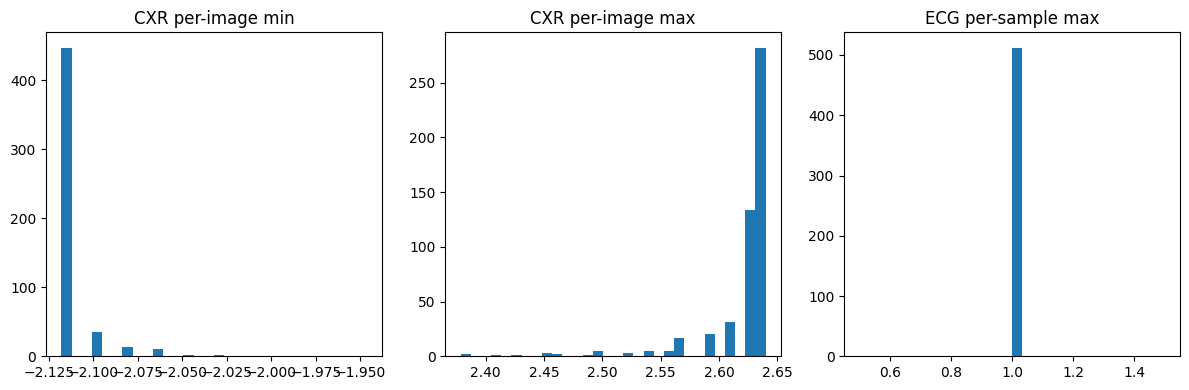

In [7]:
def validate_dataset(ds, num_samples=512):
    n = min(num_samples, len(ds))

    cxr_min, cxr_max = [], []
    ecg_min, ecg_max = [], []
    labs_pct_all = []
    labs_miss_all = []

    for i in range(n):
        s = ds[i]
        cxr = s["cxr"].numpy()
        ecg = s["ecg"].numpy()[0]          # (5000, 12)
        labs = s["labs"].numpy()

        # CXR stats
        cxr_min.append(cxr.min())
        cxr_max.append(cxr.max())

        # ECG stats
        ecg_min.append(ecg.min())
        ecg_max.append(ecg.max())

        # Labs
        labs_pct_all.append(labs[:50])
        labs_miss_all.append(labs[50:])

    labs_pct_all = np.stack(labs_pct_all, axis=0)   # (n, 50)
    labs_miss_all = np.stack(labs_miss_all, axis=0) # (n, 50)

    print("=== CXR stats ===")
    print("Pixel min across ds:", np.min(cxr_min))
    print("Pixel max across ds:", np.max(cxr_max))

    print("\n=== ECG stats ===")
    print("ECG min across ds:", np.min(ecg_min))
    print("ECG max across ds:", np.max(ecg_max))

    print("\n=== Labs percentiles stats (over all samples & dims) ===")
    print("min:", labs_pct_all.min(), "max:", labs_pct_all.max())
    print("mean:", labs_pct_all.mean(), "std:", labs_pct_all.std())

    print("\n=== Labs missingness stats ===")
    print("unique values:", np.unique(labs_miss_all))
    print("fraction of missing (≈1s):", labs_miss_all.mean())

    # Optional: sanity histograms
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(cxr_min, bins=30)
    plt.title("CXR per-image min")

    plt.subplot(1, 3, 2)
    plt.hist(cxr_max, bins=30)
    plt.title("CXR per-image max")

    plt.subplot(1, 3, 3)
    plt.hist(ecg_max, bins=30)
    plt.title("ECG per-sample max")
    plt.tight_layout()
    plt.show()

validate_dataset(test_ds, num_samples=512)

In [1]:
import numpy as np
import torch
from pathlib import Path

root = Path("../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy")  # change this to your root folder

# Iterate over all subfolders: test/, train/, val/, val_retrieval/
for subdir in root.iterdir():
    if subdir.is_dir():
        print(f"Processing folder: {subdir}")

        for npy_file in subdir.glob("*.npy"):
            arr = np.load(npy_file)
            tensor = torch.from_numpy(arr)

            pt_path = npy_file.with_suffix(".pt")
            torch.save(tensor, pt_path)

            print(f"Converted {npy_file.name} → {pt_path.name}")


Processing folder: ../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy/test
Converted cxr_test.npy → cxr_test.pt
Converted ecg_test.npy → ecg_test.pt
Converted hadm_id_test.npy → hadm_id_test.pt
Converted label_hadm_id_test.npy → label_hadm_id_test.pt
Converted label_test.npy → label_test.pt
Converted labs_missingness_test.npy → labs_missingness_test.pt
Converted labs_percentiles_test.npy → labs_percentiles_test.pt
Processing folder: ../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy/train
Converted cxr_train.npy → cxr_train.pt
Converted ecg_train.npy → ecg_train.pt
Converted hadm_id_train.npy → hadm_id_train.pt
Converted labs_missingness_train.npy → labs_missingness_train.pt
Converted labs_percentiles_train.npy → labs_percentiles_train.pt
Processing folder: ../../../scratch/physionet.org/files/symile-mimic/1.0.0/data_npy/val
Converted cxr_val.npy → cxr_val.pt
Converted ecg_val.npy → ecg_val.pt
Converted hadm_id_val.npy → hadm_id_val.pt
Converted labs_missing